In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

import post_patch as pp #post patch script
#post_patch_column = 'postPatch_label'
#post_patch_pipette_column = 'endPipetteR_label'

sns.set(style = "whitegrid")
sns.set_context('notebook')

In [2]:
#Constant and reused variables 
colors = ['#31a354', '#a1d99b', '#fc9272', '#de2d26', '#f7fcb9'] #For seaborn plots
x_order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal', 'Entire cell']

### Functions: Set-up, Filtering & Merging

In [3]:
def get_shiny_df():
    shiny_human_df = pd.read_csv('C:/users/kumar/documents/github/personal-projects/csv/shiny_human.csv')
    shiny_mouse_df = pd.read_csv('C:/users/kumar/documents/github/personal-projects/csv/shiny_mouse.csv')
    #shiny_human_df = pd.read_csv('C:/users/ramr/documents/github/coding/personal-projects/csv/shiny_human.csv')
    #shiny_mouse_df = pd.read_csv('C:/users/ramr/documents/github/coding/personal-projects/csv/shiny_mouse.csv')
    frames = (shiny_human_df, shiny_mouse_df)
    shiny_df = pd.concat(frames)
    shiny_df = shiny_df.loc[:,['sample_id', 'res_index_label', 'cluster_label']]
    return shiny_df

In [4]:
def get_json_df():
    json_df = pd.read_csv('C:/users/kumar/documents/github/personal-projects/csv/json_metadata.csv')
    #json_df = pd.read_csv('C:/users/ramr/documents/github/coding/personal-projects/csv/json_metadata.csv')
    json_df = json_df[json_df['status'] == 'SUCCESS']

    #Creates patch_duration column and outputs in minutes
    json_df['patch_duration'] = pd.to_datetime(json_df['extraction.timeRetractionEnd']) - pd.to_datetime(json_df['recording.timeWholeCellStart'])
    json_df['patch_duration'] = (json_df['patch_duration'].astype('timedelta64[s]'))/60

    json_df['date'] = json_df['date'].str[:10] #Strip away the time
    json_df['date'] = pd.to_datetime(json_df['date']) #Converting to YYYY-MM-DD

    json_df = pp.postpatch_reclass(json_df) #Makes post patch column with the script

    json_df.dropna(subset = ['patch_container'], inplace = True)
    json_df = json_df[json_df['patch_container'].str.match('PA')]

    json_df = json_df[['date',                   
                       'patch_container',
                       'roi_major',
                       'roi_minor',
                       'cell_depth',
                       'extraction.pressureApplied',
                       'patch_duration',
                       'post_patch']]
    return json_df

In [5]:
def merge_dfs(df1, df2):
    merged_df = pd.merge(left = df1, 
                         right = df2, 
                         left_on = 'patch_container',
                         right_on = 'sample_id',
                         how = 'inner')
    merged_df.drop(columns = ['sample_id'], inplace = True)
    merged_df.sort_values(by = ['date'], inplace = True) #Sorts by date column ascending
    return merged_df

### Functions: Plots

In [6]:
def pie_plot(df):
    df1 = df.groupby(['post_patch']).size().reset_index(name = 'count')
    df1.set_index('post_patch', inplace = True)
    
    explode = (0.05, 0.05, 0.05, 0.05, 0.05) #splits the categories
    colors = ['#f7fcb9','#fc9272', '#de2d26', '#31a354', '#a1d99b']
    #Entire, No-high, No-low, Nuc-high, Nuc-low
    #Yellow, Light Red, Red, Green, Light Green
    
    df1.plot.pie(y = 'count', autopct='%1.1f%%', figsize = (8,8), shadow = True, legend = False, 
                 explode = explode, colors = colors)
    plt.title('Post Patch Percentage', loc = 'center', fontsize = 14)
    plt.axes().set_ylabel('')

In [7]:
def bar_plot(df):    
    df1 = df.groupby(['post_patch']).size().reset_index(name = 'count')
    
    plt.subplots(figsize=(8,5)) #Has to be before the plot to work
    ax = sns.barplot(x = 'count', y = 'post_patch', order = x_order, palette = colors, saturation = 1, data = df1)
    ax.set(xlabel = 'Count', ylabel = 'Post Patch Outcomes')
    ax.set_title("Counts of Post Patch Outcomes for User")
    
    for p in ax.patches: #Figure out how this loop works
        value = p.get_width()
        ax.text(value, p.get_y() + p.get_height()/2 + 0.1, '{:1.0f}'.format(value), ha = "left", fontsize = 12)
        
# + 0.1 = chooses location of the value vertically

In [8]:
def violin_plot(df):
    ax = sns.violinplot(x = 'post_patch', y = 'res_index_label', order = x_order, palette = colors, 
                        saturation = 1, data = df[df.res_index_label <= 1])
    ax.set(xlabel = 'Post Patch Outcomes', ylabel = 'Resolution Index')
    ax.set_title("Resolution Index vs. Post Patch Outcomes")

#### Making global variables

In [9]:
#Making global variables
json_df = get_json_df()
shiny_df = get_shiny_df()
merged_df = merge_dfs(json_df, shiny_df)

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change t

In [10]:
merged_df.head()

,date,patch_container,roi_major,roi_minor,cell_depth,extraction.pressureApplied,patch_duration,post_patch,res_index_label,cluster_label
453,2017-10-02,PAS4_171002_451_A01,VISp,layer 4,47.4,-35.0,11.866667,No-low seal,0.434669,n59
0,2017-10-03,PAS4_171003_451_A01,VISp,layer 5,36.6,-34.0,14.483333,Nuc-high seal,0.548225,n60
1,2017-10-03,PAS4_171003_452_A01,VISp,layer 2/3,36.3,-32.0,12.500000,Nuc-high seal,1.000000,Pvalb Tpbg
2,2017-10-04,PAS4_171004_452_A01,VISp,layer 5,39.1,-40.0,9.633333,Nuc-high seal,1.000000,Sst Chodl
3,2017-10-04,PAS4_171004_453_A01,VISp,layer 2/3,36.0,-35.0,14.350000,Nuc-high seal,1.000000,L4 IT VISp Rspo1


In [11]:
merged_df.tail()

,date,patch_container,roi_major,roi_minor,cell_depth,extraction.pressureApplied,patch_duration,post_patch,res_index_label,cluster_label
321,2018-09-07,PAS4_180907_454_A01,VISp,layer 4,61.9,-40.0,9.416667,Nuc-high seal,1.000000,Sst Calb2 Pdlim5
322,2018-09-07,PAS4_180907_456_A01,VISp,layer 5,47.0,-35.0,9.500000,Nuc-high seal,0.860419,n100
323,2018-09-07,PAS4_180907_455_A01,VISp,layer 5,NaN,-37.0,12.566667,Nuc-high seal,0.866443,n98
324,2018-09-07,PAS4_180907_457_A01,VISp,layer 6a,67.1,-40.0,9.883333,Nuc-high seal,1.000000,Sst Tac2 Tacstd2
319,2018-09-07,PAS4_180907_451_A01,VISp,layer 6a,60.6,-41.0,9.216667,Nuc-high seal,1.000000,Sst Rxfp1 Eya1


In [12]:
#Outputing dataframe as excel sheet
#writer = pd.ExcelWriter('TITLE.xlsx')
#dataframe.to_excel(writer, 'Sheet#)

writer = pd.ExcelWriter('my_dataframe.xlsx')
merged_df.to_excel(writer, 'Sheet1')
writer.save()

### Main Function:

In [13]:
def main():
    """Prints out graphs and charts
    
    Arguements: none
    
    Returns: none
    """
    
    #Prints plots
    print(merged_df['post_patch'].value_counts())
    print(merged_df['post_patch'].value_counts().sum())
    pie_plot(merged_df)
    bar_plot(merged_df)
    #violin_plot(merged_df)
    
    #print(json_df['post_patch'].value_counts())
    #print(json_df['post_patch'].value_counts().sum())   
    #pie_plot(json_df)
    #bar_plot(json_df)

Nuc-high seal    325
Nuc-low seal      95
No-low seal       84
No-high seal      33
Entire cell       13
Name: post_patch, dtype: int64
550


C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


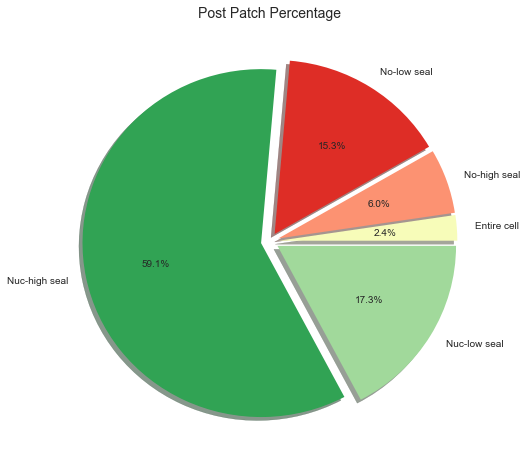

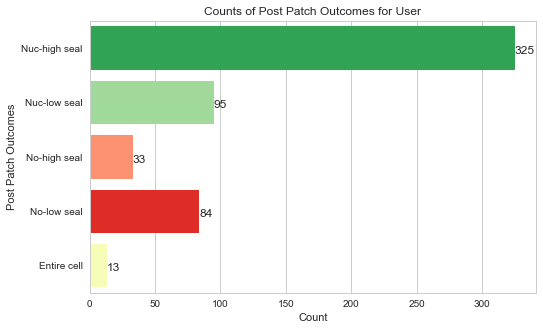

In [14]:
main()

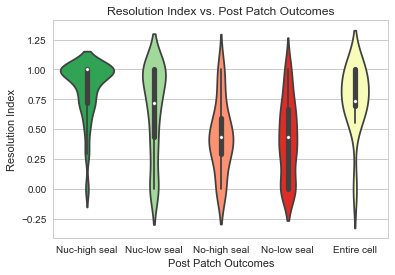

In [15]:
violin_plot(merged_df)

In [16]:
json_df['post_patch'].value_counts()

Nuc-high seal    412
Nuc-low seal     101
No-low seal       84
No-high seal      33
Entire cell       13
Name: post_patch, dtype: int64

In [17]:
json_df['post_patch'].value_counts().sum()

643

C:\Users\kumar\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


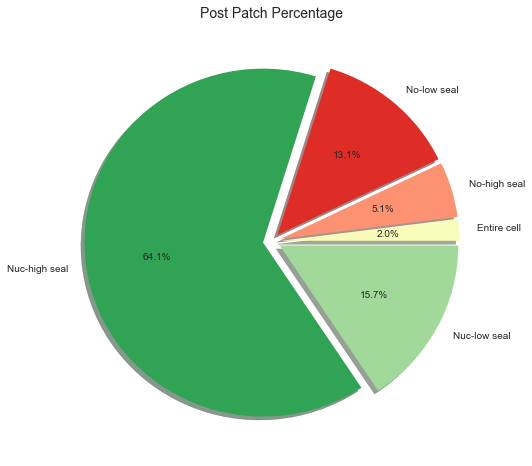

In [18]:
pie_plot(json_df)

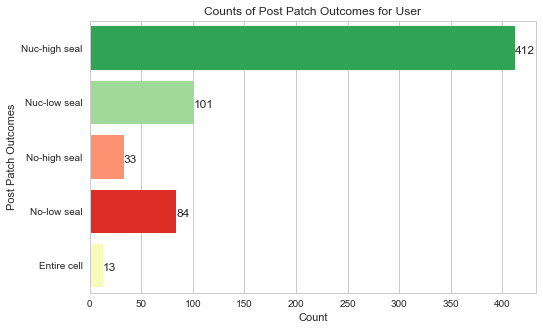

In [19]:
bar_plot(json_df)